In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Comparison and assessment of GRN inference methods

## Load GRNs inferences


In [5]:
df = pd.read_csv("Concatenation.csv",index_col=0)

In [34]:
df.head()

,rank_Fp,score_Fp,rank_Ff,score_Ff,rank_L1,score_L1,rank_genie3,score_genie3,rank_lasso,score_lasso,rank_MU,score_MU
AP-2_128up,697038.0,19.810534,697038.0,19.810534,40.0,0.00,3222376.0,0.000051,224782.0,-0.0,1491542.0,0.095487
AP-2_14-3-3epsilon,2914431.0,0.891930,2914431.0,0.891930,40.0,0.00,3599075.0,0.000010,224782.0,-0.0,2371660.0,0.036340
AP-2_14-3-3zeta,1675339.0,5.626692,1675339.0,5.626692,40.0,0.00,403323.0,0.003226,224782.0,0.0,1759208.0,0.076210
AP-2_140up,639279.0,21.589479,639279.0,21.589479,38.0,0.04,516395.0,0.002409,224782.0,0.0,2106952.0,0.053130
AP-2_18w,127334.0,66.664716,127334.0,66.664716,40.0,0.00,691518.0,0.001697,224782.0,0.0,463400.0,0.214440


In [35]:
df_rank = df[[c for c in df.columns if "rank" in c]]
df_score = df[[c for c in df.columns if "score" in c]]

In [9]:
df_rank_z = (df_rank - df_rank.mean())/df_rank.std()
df_score_z = (df_score - df_score.mean())/df_score.std()

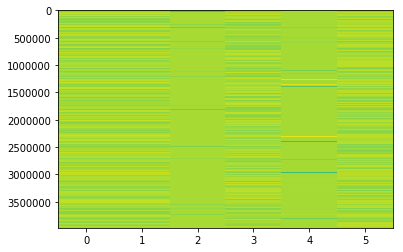

In [21]:
plt.imshow(df_rank_z,aspect="auto")

## Load "High Confidence" GRN

In [88]:
hc = pd.read_csv("high_and_medium_confidence_tf_to_predicted_target_genes_cytoscape.tsv",sep="\t",header=None)
hc.columns = ["TF","TG","confidence"]
hc.index = hc["TF"]+"_"+hc["TG"]
hc.head()

,TF,TG,confidence
abd-A_2mit,abd-A,2mit,medium
abd-A_5-HT1A,abd-A,5-HT1A,high
abd-A_5-HT1A,abd-A,5-HT1A,medium
abd-A_5-HT7,abd-A,5-HT7,high
abd-A_5-HT7,abd-A,5-HT7,medium


In [97]:
len(np.unique(hc["TF"])),len(set(hc["TF"]).intersection(set([e.split("_")[0] for e in df.index])))

(245, 245)

In [98]:
possible_links = set(hc.index).intersection(set(df.index))
hc = hc.loc[possible_links]

In [99]:
hc.shape

(122823, 3)

## Compare methods

+ Represent the correlation between the different methods using a heatmap 

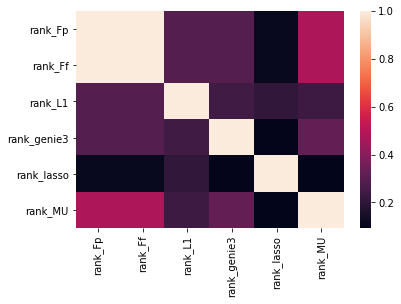

In [18]:
sns.heatmap(df_rank_z.corr())

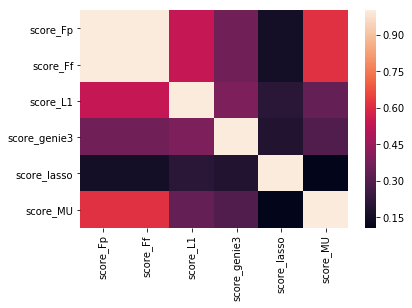

In [19]:
sns.heatmap(df_score_z.corr())

+ Generate a [dendogram](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html) or a [clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html) using the ranking or the score vectors   

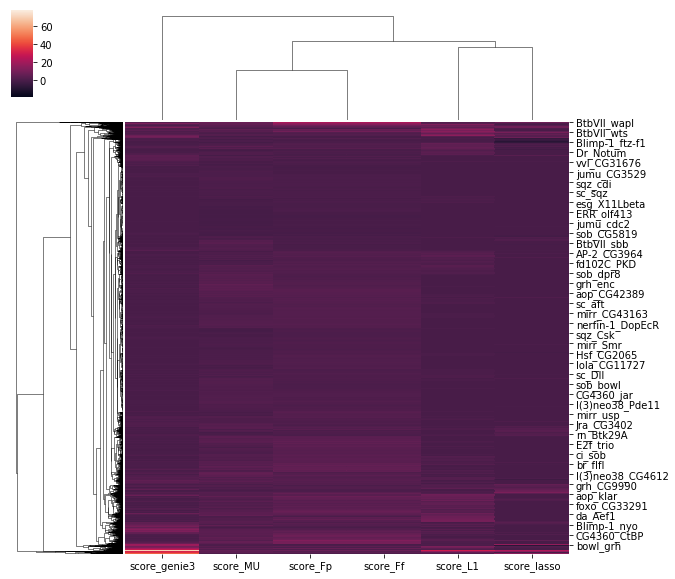

In [30]:
sns.clustermap(df_score_z.loc[hc.index])

 + Compare the top $k$ links of each method using the [Jaccard similarity score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html), represent the results in a matrix

In [36]:
from sklearn.metrics import jaccard_similarity_score

In [56]:
k=10000
jaccard_sim = pd.DataFrame(columns=df_rank.columns,index=df_rank.columns)
methods = list(jaccard_sim.columns)
for i,c in enumerate(methods[:-1]):
    top_k_c = list(df_rank[c].sort_values().index)[:k]
    for j,b in enumerate(methods[i+1:]):
        top_k_i = list(df_rank[b].sort_values().index)[:k]
        inter = len(set(top_k_i).intersection(set(top_k_c)))
        union = len(set(top_k_i).union(set(top_k_c)))
        jaccard_sim.loc[b,c] = inter/union
        jaccard_sim.loc[c,b] = jaccard_sim.loc[b,c]
        print(c,b)
    

rank_Fp rank_Ff
rank_Fp rank_L1
rank_Fp rank_genie3
rank_Fp rank_lasso
rank_Fp rank_MU
rank_Ff rank_L1
rank_Ff rank_genie3
rank_Ff rank_lasso
rank_Ff rank_MU
rank_L1 rank_genie3
rank_L1 rank_lasso
rank_L1 rank_MU
rank_genie3 rank_lasso
rank_genie3 rank_MU
rank_lasso rank_MU


In [57]:
jaccard_sim

,rank_Fp,rank_Ff,rank_L1,rank_genie3,rank_lasso,rank_MU
rank_Fp,NaN,1,0.104545,0.0870156,0.0373444,0.251564
rank_Ff,1,NaN,0.104545,0.0870156,0.0373444,0.251564
rank_L1,0.104545,0.104545,NaN,0.0928365,0.0652463,0.0716391
rank_genie3,0.0870156,0.0870156,0.0928365,NaN,0.074691,0.0894433
rank_lasso,0.0373444,0.0373444,0.0652463,0.074691,NaN,0.0308747
rank_MU,0.251564,0.251564,0.0716391,0.0894433,0.0308747,NaN


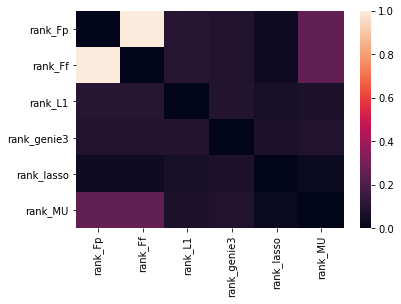

In [58]:
sns.heatmap(jaccard_sim.fillna(0))

+ For each method, keep only the edges that are reported in the "high confidence" GRN.
+ Apply a [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to the rankings of the methods for the chosen links, keep 3 dimensions, and the location of each method in this new space (you go from $M$ points in a $|E_{HC}|$-th dimensional space to $M$ points in a 3D space ). 

__Check the following example:__

                  score_Fp   score_Ff  score_L1  score_genie3  score_lasso  \
lola_clt         -0.395138  -0.395138 -0.210425     -0.166242    -0.043711   
Xbp1_Syx5         0.465924   0.465924  0.547407      0.947467     7.452334   
E2f_flfl         10.315223  10.315223  1.305238      0.037365    -0.043711   
grh_CG32479       2.696419   2.696419  0.547407     -0.115135    -0.043711   
srp_BM-40-SPARC   1.904669   1.904669  8.125720     42.921821    16.380173   

                 score_MU  
lola_clt        -0.895213  
Xbp1_Syx5       -0.374862  
E2f_flfl         4.819065  
grh_CG32479      2.104183  
srp_BM-40-SPARC  2.222184  

Explained variance ratio for each PC
[0.53746059 0.23295944 0.15957145]


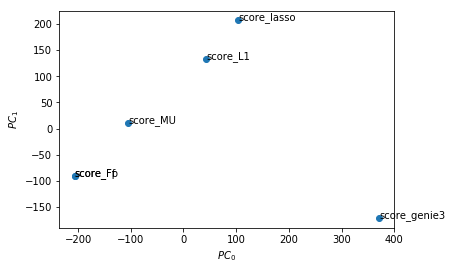

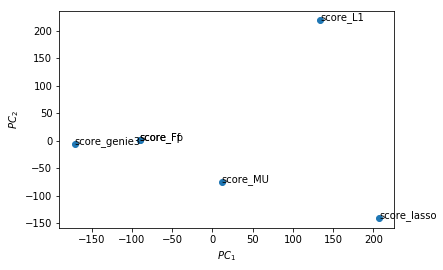

In [63]:
# create a dummy join ranking of 10 methods and 100 edges
rankings = df_score_z.loc[possible_links]
print(rankings.head())
# transpose the ranking matrix
rankingsT = rankings.T
# import PCA
from sklearn.decomposition import PCA
# create PCA object with k principal axis
k = 3
pca = PCA(n_components=k)
# Apply the PCA
rankingsT_pca = pca.fit_transform(rankingsT)
# Explained variance ratio for each principal axis
print("\nExplained variance ratio for each PC")
print(pca.explained_variance_ratio_)
# plot the coordinates of each method along the Principal Axis
plt.plot(rankingsT_pca[:,0],rankingsT_pca[:,1],"o")
plt.xlabel("$PC_0$")
plt.ylabel("$PC_1$")
for i,method in enumerate(rankingsT.index):
    plt.text(x=rankingsT_pca[i,0], y=rankingsT_pca[i,1], s=method)
plt.figure()  
plt.plot(rankingsT_pca[:,1],rankingsT_pca[:,2],"o")
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
for i,method in enumerate(rankingsT.index):
    plt.text(x=rankingsT_pca[i,1], y=rankingsT_pca[i,2], s=method)
    
    

## Assess the quality of the inferred GRNs
In this section we are going to use the following quality measures to evaluate the inferred GRNs with respect to the "High Confidence" GRN:

+ [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
+ [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
+ [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

These measures are defined using the __confusion matrix__
$$ConfMat=\begin{pmatrix}& T_{real} & F_{real}\\T_{pred}& TP & FP \\F_{pred} & FN & TN \end{pmatrix}$$

__Where__:
+ $TP$: True positive (correctly predicted as True)
+ $FP$: False positive (wrongly predicted as True)
+ $FN$: False negative (wrongly predicted as False)
+ $TN$: True negative (correctly predicted as False)

__Metrics__:
+ $Recall = \frac{TP}{TP + FN}$
+ $Precision = \frac{TP}{TP + FP}$
+ $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

__Bonus__:
You can also use the follwing evaluation criteria:
+ [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
+ [AUC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
+ [Average Precision Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

+ Select the to $k = |E_{HC}|$ best edges for each method
+ Evaluate the different results with respect to the "High Confidence" GRN using the previous measures
+ Which are the best methods, w.r.t. this dataset? Explain

In [64]:
from sklearn.metrics import precision_score,recall_score,accuracy_score

In [93]:
k = 16000
total_best_links = set(possible_links)
top_K = {}
for c in df_rank.columns:
    top_k_c = list(df_rank[c].sort_values().index)[:k]
    total_best_links = total_best_links.union(top_k_c)
    top_K[c] = top_k_c

In [94]:
results = {}
for c in top_K:
    y_pred = pd.Series(0,index=total_best_links)
    y_true = pd.Series(0,index=total_best_links)
    y_pred[top_K[c]] = 1
    y_true[possible_links] = 1
    acc = accuracy_score(y_pred=y_pred,y_true=y_true)
    rec = recall_score(y_pred=y_pred,y_true=y_true)
    pre = precision_score(y_pred=y_pred,y_true=y_true)
    results[c] = {"accuracy":acc,"recall":rec,"precision":pre}
    print(c, len(set(top_K[c]).intersection(possible_links)), len(set(top_K[c]).union(possible_links)))
results = pd.DataFrame(results)

rank_Fp 2144 122382
rank_Ff 2144 122382
rank_L1 1512 123014
rank_genie3 1906 122620
rank_lasso 1045 123481
rank_MU 2281 122245


In [95]:
results

,rank_Fp,rank_Ff,rank_L1,rank_genie3,rank_lasso,rank_MU
accuracy,0.256312,0.256312,0.248494,0.253368,0.242717,0.258007
precision,0.134000,0.134000,0.094500,0.119125,0.065312,0.142563
recall,0.019756,0.019756,0.013932,0.017563,0.009629,0.021018


# Build a meta learner
In [Marbach et al. 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3512113/), the authors have suggest that "no single inference method performs optimally across all datasets. In contrast, integration of predictions from multiple inference methods shows robust and high performance across diverse datasets"

+ Compute a new GRN by averaging the ranks of the different methods. 

In [106]:
df_rank["rank_average"] = df_rank.mean(axis=1)
k = 10000
total_best_links = set(possible_links)
top_K = {}
for c in df_rank.columns:
    top_k_c = list(df_rank[c].sort_values().index)[:k]
    total_best_links = total_best_links.union(top_k_c)
    top_K[c] = top_k_c
results = {}
for c in top_K:
    y_pred = pd.Series(0,index=total_best_links)
    y_true = pd.Series(0,index=total_best_links)
    y_pred[top_K[c]] = 1
    y_true[possible_links] = 1
    acc = accuracy_score(y_pred=y_pred,y_true=y_true)
    rec = recall_score(y_pred=y_pred,y_true=y_true)
    pre = precision_score(y_pred=y_pred,y_true=y_true)
    results[c] = {"accuracy":acc,"recall":rec,"precision":pre}
    print(c, len(set(top_K[c]).intersection(possible_links)), len(set(top_K[c]).union(possible_links)))
results = pd.DataFrame(results)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


rank_Fp 1390 117136
rank_Ff 1390 117136
rank_L1 981 117545
rank_genie3 1323 117203
rank_lasso 719 117807
rank_MU 1456 117070
rank_average 1548 116978


In [107]:
results

,rank_Fp,rank_Ff,rank_L1,rank_genie3,rank_lasso,rank_MU,rank_average
accuracy,0.196744,0.196744,0.191067,0.195814,0.187431,0.197660,0.198937
precision,0.139000,0.139000,0.098100,0.132300,0.071900,0.145600,0.154800
recall,0.012808,0.012808,0.009039,0.012191,0.006625,0.013416,0.014264


+ Compute the similarity of this new GRN w.r.t. the previous ones

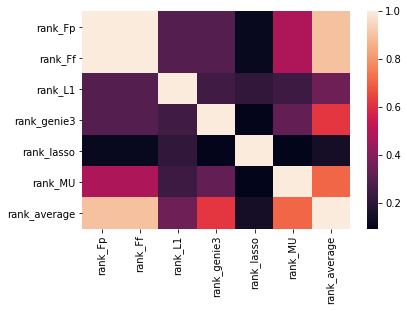

In [109]:
sns.heatmap(df_rank.corr())

+ Let $X^{rank}$ be a matrix with $E$ rows (one for each edge) and $M$ columns (one for each method). The value $X^{rank}_{i,j}$ is the rank that method $j$ has attributed to edge $i$. 
+ Let $y$ be a binary label vector with $E$ rows (one for each edge), s.t. $y_e=1$ if $e \in E_{HC}$ and $y_e=0$ otherwise
+ Train a Random Forest classifier to predict $y$, from the values $X_{rank}$
+ Extract the feature importance from this classifier to infer which are the better methods

__Check the following example:__

In [123]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [110]:
rankings = df_rank.loc[total_best_links]
y = pd.DataFrame()
y["labels"] = y_true

array([0.0689658 , 0.06933868, 0.17540625, 0.22551546, 0.23318317,
       0.08801744, 0.1395732 ])

In [112]:
# Train the RF classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)

In [124]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

In [125]:
scores = cross_validate(rf, rankings, y["labels"], cv=skf,scoring=['f1','recall','precision','accuracy'])


In [126]:
scores

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning

{'fit_time': array([13.40377903, 11.63035178, 13.84735227, 15.5873313 , 13.51631999]),
 'score_time': array([1.29449987, 0.92264795, 1.06069398, 0.97042775, 0.99701929]),
 'test_f1': array([0.97895825, 0.97918624, 0.98013462, 0.97835844, 0.97924103]),
 'train_f1': array([0.99997696, 1.        , 0.99998272, 0.99998848, 1.        ]),
 'test_recall': array([0.96024141, 0.9601935 , 0.96268141, 0.95913384, 0.96060815]),
 'train_recall': array([0.99995393, 1.        , 0.99996545, 0.99997696, 1.        ]),
 'test_precision': array([0.99841924, 0.9989455 , 0.99823237, 0.99836946, 0.99861104]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.96891048, 0.96925639, 0.97060967, 0.96804192, 0.96932579]),
 'train_accuracy': array([0.9999653 , 1.        , 0.99997398, 0.99998265, 1.        ])}